In [145]:
import os
import re
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from datetime import timedelta
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from konlpy.tag import Okt
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [146]:
data_dic = {}
idx = 0

for curDir, dirs, files in tqdm(os.walk("./NewsData")):
    for f in files:
        try:
            path = os.path.join(curDir, f)
            data = pd.read_csv(path, encoding='cp949')
            data_dic[idx] = data
        except:
            path = os.path.join(curDir, f)
            print(f'========={path} ERROR=========')
        idx += 1

381it [00:56,  6.75it/s]


In [147]:
# df = pd.read_csv('./Data/Khaiii.csv')
# # df['Date'] = pd.to_datetime(df['Date'])

In [148]:
positive = pd.read_csv('../4.프로젝트/Data/Positive.csv', encoding='cp949')
negative = pd.read_csv('../4.프로젝트/Data/Negative.csv', encoding='cp949')

positive.columns = ['word', 'value']
negative.columns = ['word', 'value']

positive_dict = positive.set_index('word').T.to_dict('records')[0]
negative_dict = negative.set_index('word').T.to_dict('records')[0]

In [149]:
# df = pd.concat(data_dic).reset_index(drop=True)

# df['Date'] = df['Date'].apply(lambda x: x.split('.')[0] + '-' + x.split('.')[1] + '-' + x.split('.')[2])
# df['Date'] = pd.to_datetime(df['Date'])
# df['Title_Article'] = df['Title'] + df['Article']

In [150]:
def positive_sentiment(data, columns, positive_dict=positive_dict, negative_dict=negative_dict):
    
    positive = []

    for article in tqdm(data[columns]):
        
        positive_score = 0
        article = article.split(' ')
        
        for word in article:
            try:
                p_score = positive_dict[word]
                positive_score += p_score
            except:
                None

        positive.append(positive_score)

    positive_sr = pd.Series(positive)
        
    return positive_sr

In [151]:
def negative_sentiment(data, columns, positive_dict=positive_dict, negative_dict=negative_dict):
    
    negative = []

    for article in tqdm(data[columns]):
        
        negative_score = 0
        article = article.split(' ')
        
        for word in article:
            try:
                n_score = negative_dict[word]
                negative_score += n_score
            except:
                None

        negative.append(negative_score)
    
    negative_sr = pd.Series(negative)
    
    return negative_sr

In [152]:
positive_sr = positive_sentiment(df, 'Title_Article')
negative_sr = negative_sentiment(df, 'Title_Article')

sentiment_df = df.copy()

100%|██████████| 1584147/1584147 [01:22<00:00, 19156.53it/s]


In [153]:
print(positive_sr[(positive_sr == 0)].count())
print(negative_sr[(negative_sr == 0)].count())

198223
621364


In [154]:
sentiment_df['positive_score'] = positive_sr
sentiment_df['negative_score'] = negative_sr

In [155]:
sentiment_df = sentiment_df[sentiment_df['positive_score'] != 0]
sentiment_df = sentiment_df[sentiment_df['negative_score'] != 0]

In [156]:
sentiment_df['sentiment_score'] = sentiment_df['positive_score'] - sentiment_df['negative_score']

In [157]:
sentiment_df[['positive_score', 'negative_score']].describe()

,positive_score,negative_score
count,896293.0000,896293.0000
mean,6.5151,3.6126
std,5.9708,4.0569
min,0.3400,0.3400
25%,2.3580,0.8400
50%,4.8100,2.1300
75%,8.8020,4.7180
max,125.5380,93.1420


In [143]:
sentiment_df[['sentiment_score']].describe()

,sentiment_score
count,896293.0000
mean,2.9024
std,6.2771
min,-72.7560
25%,-0.3020
50%,1.9780
75%,5.6080
max,106.0440


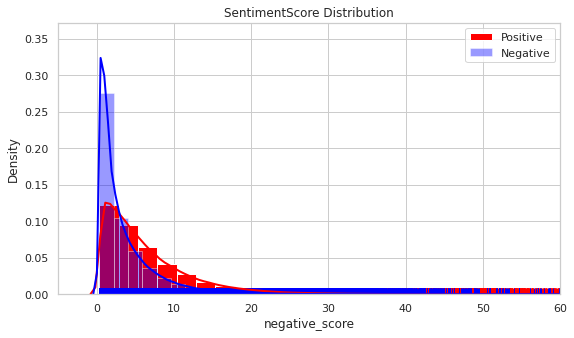

In [144]:
plt.figure(figsize=(9, 5))


sns.distplot(sentiment_df['positive_score'], 
             hist_kws={'alpha':1}, 
             kde_kws={'linewidth': 2, 'alpha':1},
             label='Positive', color='red', rug=True)

sns.distplot(sentiment_df['negative_score'], 
             hist_kws={'alpha':0.4}, 
             kde_kws={'linewidth': 2, 'alpha':0.5},
             label='Negative', color='blue', rug=True)

plt.xlim(-5, 60)
plt.legend()
plt.title('SentimentScore Distribution')
plt.show()

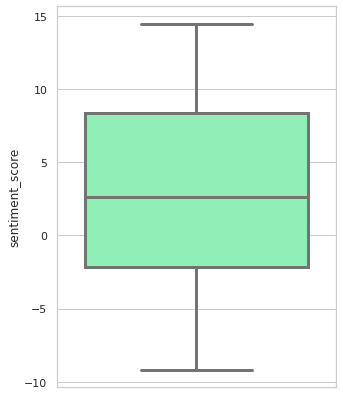

In [129]:
plt.figure(figsize=(5,7))
sns.boxplot(y=final_df['sentiment_score'], palette='rainbow', linewidth=3, dodge=False)
# sns.swarmplot(y='sentiment_score', data=final_df.sample(5000), color='k', alpha=0.5)
plt.show()

In [99]:
iqr = np.quantile(sentiment_df['sentiment_score'], 0.75) - np.quantile(sentiment_df['sentiment_score'], 0.25)

max_value = np.quantile(sentiment_df['sentiment_score'], 0.75) + (1.5 * iqr)
min_value = np.quantile(sentiment_df['sentiment_score'], 0.25) - (1.5 * iqr)

In [100]:
positive_df = sentiment_df[(sentiment_df['sentiment_score'] <= max_value) & (sentiment_df['sentiment_score'] > np.quantile(sentiment_df['sentiment_score'], 0.75))]
negative_df = sentiment_df[(sentiment_df['sentiment_score'] >= min_value) & (sentiment_df['sentiment_score'] < np.quantile(sentiment_df['sentiment_score'], 0.25))]

In [101]:
print(positive_df.shape)
print(negative_df.shape)

(183297, 7)
(206194, 7)


In [102]:
positive_df = positive_df.sample(50000)
negative_df = negative_df.sample(50000)

In [103]:
final_positive = positive_df[['Title_Article', 'sentiment_score']]
final_negative = negative_df[['Title_Article', 'sentiment_score']]

final_positive['sentiment'] = 1
final_negative['sentiment'] = 0

In [91]:
final_positive = final_positive.drop(['sentiment_score'], axis=1)
final_negative = final_negative.drop(['sentiment_score'], axis=1)

In [104]:
final_df = pd.concat([final_positive, final_negative]).sample(frac=1).reset_index(drop=True)

In [ ]:
final_df.to_csv('SentimentData.csv', index=False)